In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd

def calculate_correlation_signals(
    data: pd.DataFrame,
    asset1: str,
    asset2: str,
    window: int = 50,
    wide_window: int = 100,
    std_factor: float = 3.0
) -> pd.DataFrame:
    """
    Computes a rolling correlation between two assets and generates trading signals
    based on deviations from a longer rolling average correlation.

    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame with historical price data, which must include columns for `asset1` and `asset2`.
    asset1 : str
        Column name for the first asset in the DataFrame.
    asset2 : str
        Column name for the second asset in the DataFrame.
    window : int, optional
        Number of periods used for computing the short rolling correlation (default is 50).
    wide_window : int, optional
        Number of periods used for computing the longer rolling average and standard deviation 
        of the correlation (default is 100).
    std_factor : float, optional
        Multiplier for the standard deviation to determine upper and lower thresholds (default is 3.0).

    Returns:
    --------
    pd.DataFrame
        A DataFrame with columns:
        - 'rolling_corr': The short-window rolling correlation between asset1 and asset2.
        - 'avg_corr': The wide-window rolling average of 'rolling_corr'.
        - 'upper_threshold': avg_corr + (std_factor * std_corr).
        - 'lower_threshold': avg_corr - (std_factor * std_corr).
        - 'signal': Integer signals indicating conditions:
            * -1 if rolling_corr > upper_threshold  (asset likely to revert downward)
            *  2 if rolling_corr < lower_threshold  (asset likely to revert upward)
            *  0 otherwise
    """
    # Validate column names
    for col in [asset1, asset2]:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' not found in DataFrame.")
    
    df = data.copy()

    # Compute rolling correlation using the short window
    df['rolling_corr'] = (
        df[asset1]
          .rolling(window=window, min_periods=window)
          .corr(df[asset2])
    )
    
    # Compute wide-window stats (average and std dev of correlation)
    df['avg_corr'] = df['rolling_corr'].rolling(window=wide_window, min_periods=10).mean()
    df['std_corr'] = df['rolling_corr'].rolling(window=wide_window, min_periods=10).std()
    
    # Compute upper and lower thresholds using std_factor
    df['upper_threshold'] = df['avg_corr'] + (std_factor * df['std_corr'])
    df['lower_threshold'] = df['avg_corr'] - (std_factor * df['std_corr'])

    # Initialize signals to 0
    df['signal'] = 0
    
    # If correlation is above the upper threshold, set signal to -1 (expecting revert downward)
    df.loc[df['rolling_corr'] > df['upper_threshold'], 'signal'] = -1
    
    # If correlation is below the lower threshold, set signal to 2 (expecting revert upward)
    df.loc[df['rolling_corr'] < df['lower_threshold'], 'signal'] = 2
    
    # Return only the relevant columns
    return df[['rolling_corr', 'avg_corr', 'upper_threshold', 'lower_threshold', 'signal']]



def plot_correlation_signals(df: pd.DataFrame, start_idx: int = None, end_idx: int = None) -> None:
    """
    Plots rolling correlation and signals within a designated index range.
    
    Parameters:
    - df (pd.DataFrame): DataFrame with columns ['rolling_corr', 'avg_corr',
      'upper_threshold', 'lower_threshold', 'signal'] (as returned by calculate_correlation_signals).
    - start_idx (int or None): Start index for slicing the data.
    - end_idx (int or None): End index for slicing the data.
    """
    # Filter data based on the given index range
    if start_idx is not None and end_idx is not None:
        df = df.iloc[start_idx:end_idx]
    
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['rolling_corr'], label='Rolling Correlation', color='blue')
    plt.plot(df.index, df['avg_corr'], label='Average Correlation', linestyle='--', color='green')
    plt.fill_between(
        df.index,
        df['lower_threshold'],
        df['upper_threshold'],
        color='gray',
        alpha=0.2,
        label='Threshold Range'
    )
    
    # Highlight buy/sell signals
    buy_signals = df[df['signal'] == 2]
    sell_signals = df[df['signal'] == -1]
    plt.scatter(buy_signals.index, buy_signals['rolling_corr'], color='red', marker='^', 
                label='Lower Signal', alpha=0.7)
    plt.scatter(sell_signals.index, sell_signals['rolling_corr'], color='black', marker='v', 
                label='Upper Signal', alpha=0.7)
    
    plt.title('Rolling Correlation and Trading Signals')
    plt.xlabel('Date')
    plt.ylabel('Correlation')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_asset_prices(data: pd.DataFrame, start_idx: int = None, end_idx: int = None) -> None:
    """
    Plots the closing prices of the two assets within a designated index range.
    
    Parameters:
    - data (pd.DataFrame): DataFrame containing price columns (e.g., 'Asset1' and 'Asset2').
                           The index should be dates.
    - start_idx (int or None): Start index for slicing the data.
    - end_idx (int or None): End index for slicing the data.
    """
    # Filter data based on the given index range
    if start_idx is not None and end_idx is not None:
        data = data.iloc[start_idx:end_idx]
    
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data.iloc[:, 0], label=data.columns[0], color='blue')
    plt.plot(data.index, data.iloc[:, 1], label=data.columns[1], color='green')
    plt.title('Asset Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()


In [2]:
import yfinance as yf

def fetch_stock_data(ticker, max_period='max'):
    stock = yf.Ticker(ticker)
    data = stock.history(period=max_period, interval='1d')
    return data['Close']

In [3]:
# Fetch the maximum duration of daily closing prices for Apple and Microsoft
asset1_ticker = 'AAPL'
asset2_ticker = 'MSFT'

asset1_prices = fetch_stock_data(asset1_ticker)
asset2_prices = fetch_stock_data(asset2_ticker)

# Align both datasets to the same date range
data = pd.concat([asset1_prices, asset2_prices], axis=1, join='inner')
data.columns = [asset1_ticker, asset2_ticker]

# Calculate correlation signals
result = calculate_correlation_signals(data, asset1_ticker, asset2_ticker, window=50, wide_window=100, std_factor=1)

In [4]:
data.head(20)

,AAPL,MSFT
Date,,
1986-03-13 00:00:00-05:00,0.084990,0.059707
1986-03-14 00:00:00-05:00,0.089712,0.061839
1986-03-17 00:00:00-05:00,0.089282,0.062906
1986-03-18 00:00:00-05:00,0.092288,0.061306
1986-03-19 00:00:00-05:00,0.091000,0.060240
1986-03-20 00:00:00-05:00,0.097009,0.058641
1986-03-21 00:00:00-05:00,0.094863,0.057042
1986-03-24 00:00:00-05:00,0.091858,0.055443
1986-03-25 00:00:00-05:00,0.095721,0.056509


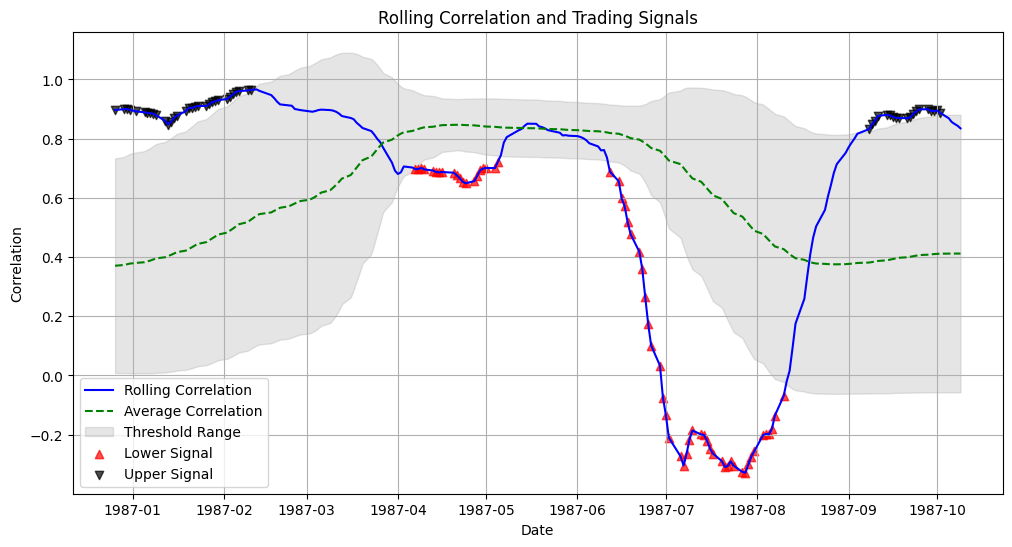

In [5]:
# Plot correlation signals
plot_correlation_signals(result, start_idx=200, end_idx=400)

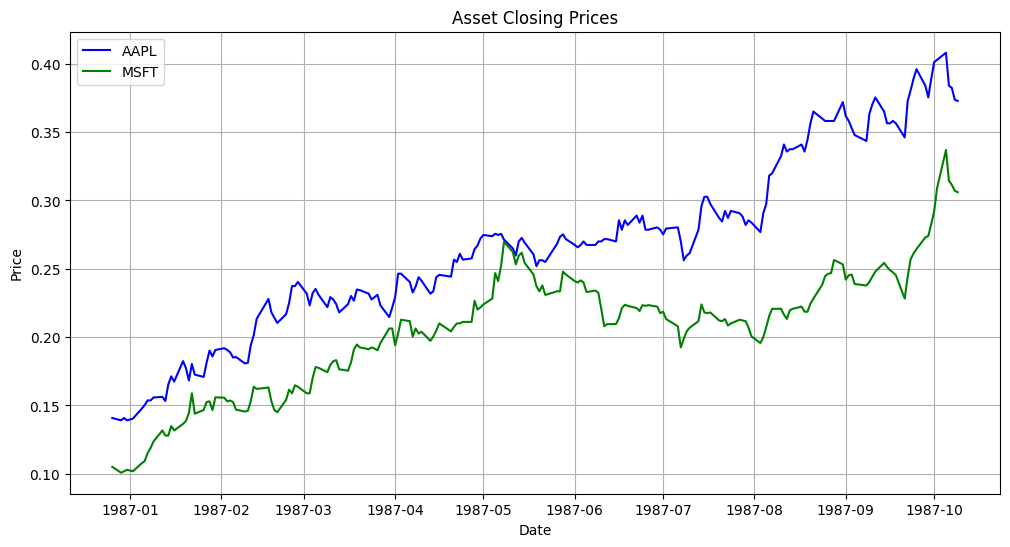

In [17]:
# Plot asset prices
plot_asset_prices(data, start_idx=200, end_idx=400)

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_combined_data(price_data: pd.DataFrame, correlation_data: pd.DataFrame, start_idx: int = None, end_idx: int = None) -> None:
    """
    Plots asset closing prices and rolling correlation signals within a designated index range on a single graph.
    
    Parameters:
    - price_data (pd.DataFrame): DataFrame containing price columns (e.g., 'Asset1' and 'Asset2').
                                 The index should be dates.
    - correlation_data (pd.DataFrame): DataFrame with columns ['rolling_corr', 'avg_corr',
      'upper_threshold', 'lower_threshold', 'signal'] (as returned by calculate_correlation_signals).
    - start_idx (int or None): Start index for slicing the data.
    - end_idx (int or None): End index for slicing the data.
    """
    # Filter data based on the given index range
    if start_idx is not None and end_idx is not None:
        price_data = price_data.iloc[start_idx:end_idx]
        correlation_data = correlation_data.iloc[start_idx:end_idx]
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot asset prices
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='black')
    ax1.plot(price_data.index, price_data.iloc[:, 0], label=price_data.columns[0], color='blue')
    ax1.plot(price_data.index, price_data.iloc[:, 1], label=price_data.columns[1], color='green')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    
    # Create a second y-axis for the correlation data
    ax2 = ax1.twinx()
    ax2.set_ylabel('Correlation', color='purple')
    #ax2.set_ylim(-1, 1)  # Ensure correlation axis is always between -1 and +1
    ax2.plot(correlation_data.index, correlation_data['rolling_corr'], label='Rolling Correlation', color='purple')
    ax2.plot(correlation_data.index, correlation_data['avg_corr'], label='Average Correlation', linestyle='--', color='orange')
    ax2.fill_between(
        correlation_data.index,
        correlation_data['lower_threshold'],
        correlation_data['upper_threshold'],
        color='gray',
        alpha=0.2,
        label='Threshold Range'
    )
    ax2.tick_params(axis='y', labelcolor='purple')
    
    # Highlight buy/sell signals
    buy_signals = correlation_data[correlation_data['signal'] == 2]
    sell_signals = correlation_data[correlation_data['signal'] == -1]
    ax2.scatter(buy_signals.index, buy_signals['rolling_corr'], color='red', marker='^', 
                label='Lower Signal', alpha=0.7)
    ax2.scatter(sell_signals.index, sell_signals['rolling_corr'], color='black', marker='v', 
                label='Upper Signal', alpha=0.7)
    
    ax2.legend(loc='upper right')
    
    plt.title('Asset Prices and Rolling Correlation')
    plt.show()

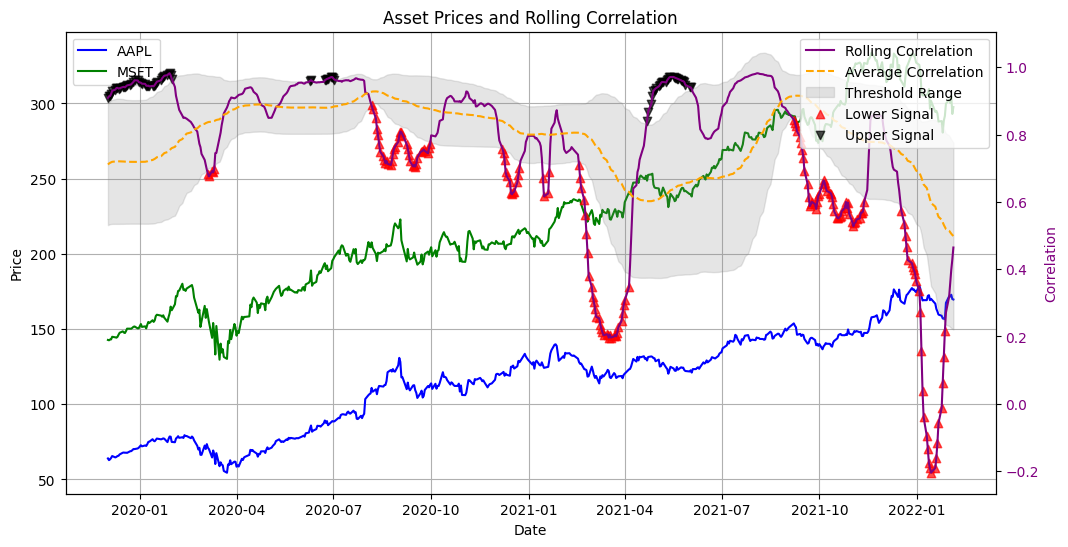

In [19]:
plot_combined_data(data, result, start_idx=8500, end_idx=9050)

In [9]:
data

,AAPL,MSFT
Date,,
1986-03-13 00:00:00-05:00,0.084990,0.059707
1986-03-14 00:00:00-05:00,0.089712,0.061839
1986-03-17 00:00:00-05:00,0.089282,0.062906
1986-03-18 00:00:00-05:00,0.092288,0.061306
1986-03-19 00:00:00-05:00,0.091000,0.060240
...,...,...
2025-03-03 00:00:00-05:00,238.029999,388.489990
2025-03-04 00:00:00-05:00,235.929993,388.609985
2025-03-05 00:00:00-05:00,235.740005,401.019989
